<a href="https://colab.research.google.com/github/paulamartingonzalez/GNN-expl/blob/main/Captum.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install dgl 
!pip install -q captum

     |████████████████████████████████| 1.4 MB 15.4 MB/s 


In [109]:
import dgl
import torch
import torch.nn as nn
import torch.nn.functional as F
from dgl.dataloading import GraphDataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from dgl.nn import GraphConv,EdgeWeightNorm
from random import randint
from torch.utils.data import DataLoader
from scipy.sparse import coo_matrix
from scipy import sparse
from captum.attr import Saliency, IntegratedGradients
from functools import partial
import pandas as pd

# Create random graphs for graph classification

In [82]:
gs=[]
node_number = 20
initial_nodes = 2
node_feats=4


for i in range(25):
    G = nx.barabasi_albert_graph(node_number, initial_nodes)
    A = nx.adjacency_matrix(G)
    g = dgl.DGLGraph(A)
    g.ndata['h_n'] = torch.randn(g.num_nodes(), node_feats)
    label = randint(0, 1)
    gs.append((g,label))

/usr/local/lib/python3.7/dist-packages/dgl/base.py:45: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  return warnings.warn(message, category=category, stacklevel=1)


# Define model

In [83]:
class GCN_edgefeats(nn.Module):
    def __init__(self, in_feats, h_feats, num_classes):
        super(GCN_edgefeats, self).__init__()
        self.conv1 = GraphConv(in_feats, h_feats)
        self.conv2 = GraphConv(h_feats, num_classes)
        self.w = EdgeWeightNorm()
        self.out_act = nn.Sigmoid()
    def forward(self, g, in_feat,edge_weight):
        norm = self.w(g, edge_weight)
        h = self.conv1(g, in_feat,edge_weight=norm)
        h = F.relu(h)
        h = self.conv2(g, h,edge_weight=norm)
        g.ndata['h'] = h
        return self.out_act(dgl.mean_nodes(g, 'h'))

# Dataloader

In [84]:
def collate(samples):
    # The input `samples` is a list of pairs
    #  (graph, label).
    graphs, labels = map(list, zip(*samples))
    batched_graph = dgl.batch(graphs)
    return batched_graph, torch.tensor(labels)

In [85]:
train_dataloader = DataLoader(gs, batch_size=int(10), shuffle=True,
                            collate_fn=collate)

# Train

In [139]:
# Create the model with given dimensions
model = GCN_edgefeats(4, 16, 1)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_func = nn.BCELoss()

for epoch in range(20):
    for batched_graph, labels in train_dataloader:
        edge_weight = (torch.randn(batched_graph.num_edges()) ** 2).requires_grad_() 
        # edge_weight = torch.tensor(batched_graph.adj(scipy_fmt='coo').todense())
        pred = model(batched_graph, batched_graph.ndata['h_n'].float(),edge_weight)
        loss = loss_func(pred.round(), labels.unsqueeze(1).float())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


# Get node importances

Select one graph:

In [140]:
graphs = dgl.unbatch(batched_graph)
G = graphs[2]
edge_weight = (torch.randn(G.num_edges()) ** 2).requires_grad_() 

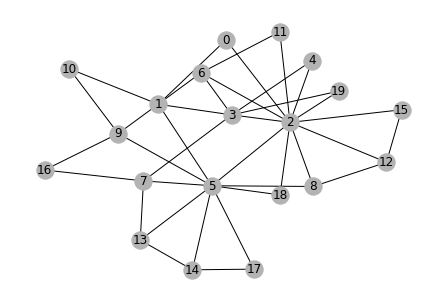

In [141]:
nx_G = G.to_networkx().to_undirected()
# Kamada-Kawaii layout usually looks pretty for arbitrary graphs
pos = nx.kamada_kawai_layout(nx_G)
nx.draw(nx_G, pos, with_labels=True, node_color=[[.7, .7, .7]])

Integrated gradients

In [142]:
ig = IntegratedGradients(partial(model, G,edge_weight=edge_weight))
mask = ig.attribute(G.ndata['h_n'].float(), target=0, internal_batch_size=5, n_steps=50)

/usr/local/lib/python3.7/dist-packages/captum/attr/_utils/batching.py:49: UserWarning: Internal batch size cannot be less than the number of input examples. Defaulting to internal batch size of 20 equal to the number of examples.
  % num_examples


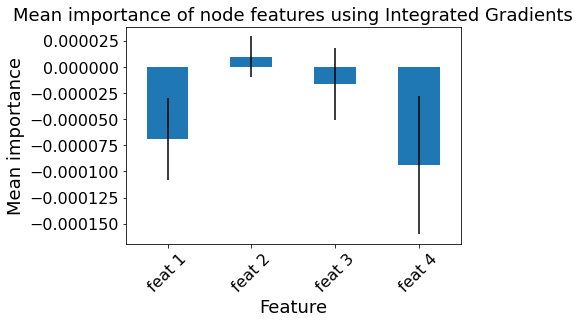

In [143]:
df = pd.DataFrame(data=mask.detach().numpy(), index=None, columns=['feat 1','feat 2','feat 3','feat 4'])
mymean = df.mean()
mysem = df.sem()

p = mymean.plot(legend=False,kind="bar",rot=45,fontsize=16,yerr=mysem);
p.set_title("Mean importance of node features using Integrated Gradients", fontsize=18);
p.set_xlabel("Feature", fontsize=18);
p.set_ylabel("Mean importance", fontsize=18);


Saliency maps

In [144]:
ig = Saliency(partial(model, G,edge_weight=edge_weight))
mask = ig.attribute(G.ndata['h_n'].float(), target=0)

/usr/local/lib/python3.7/dist-packages/captum/_utils/gradient.py:59: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  "required_grads has been set automatically." % index


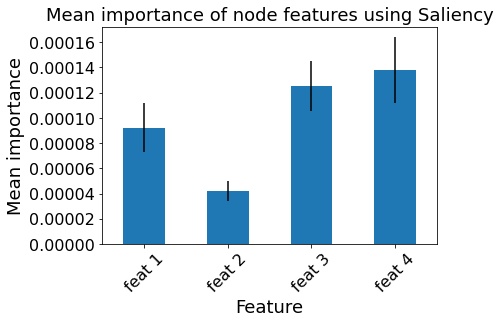

In [145]:
df = pd.DataFrame(data=mask.detach().numpy(), index=None, columns=['feat 1','feat 2','feat 3','feat 4'])
mymean = df.mean()
mysem = df.sem()

p = mymean.plot(legend=False,kind="bar",rot=45,fontsize=16,yerr=mysem);
p.set_title("Mean importance of node features using Saliency", fontsize=18);
p.set_xlabel("Feature", fontsize=18);
p.set_ylabel("Mean importance", fontsize=18);


# Get edge importances


In [147]:
ig = IntegratedGradients(partial(model, batched_graph,in_feat=batched_graph.ndata['h_n'].float()))
mask = ig.attribute(edge_weight, target=0, internal_batch_size=5, n_steps=50)

/usr/local/lib/python3.7/dist-packages/captum/attr/_utils/batching.py:49: UserWarning: Internal batch size cannot be less than the number of input examples. Defaulting to internal batch size of 72 equal to the number of examples.
  % num_examples


TypeError: ignored